In [1]:
'''Clear out temporary variables and get a clean session'''
try:
    from IPython import get_ipython
    get_ipython().magic('clear')
    get_ipython().magic('reset -f')
except:
    pass

In [74]:
'''Import necessary libraries'''
import pandas as pd
import numpy as np
import os
import glob
import re
import math

import missingno as msno
import pickle
import bz2

import sklearn
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import set_config
from pca import pca
#from sklearn import missingpy
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
'''Open pickled file'''
with open('mib_final.pkl', 'rb') as f:
    df = pickle.load(f)

<AxesSubplot:>

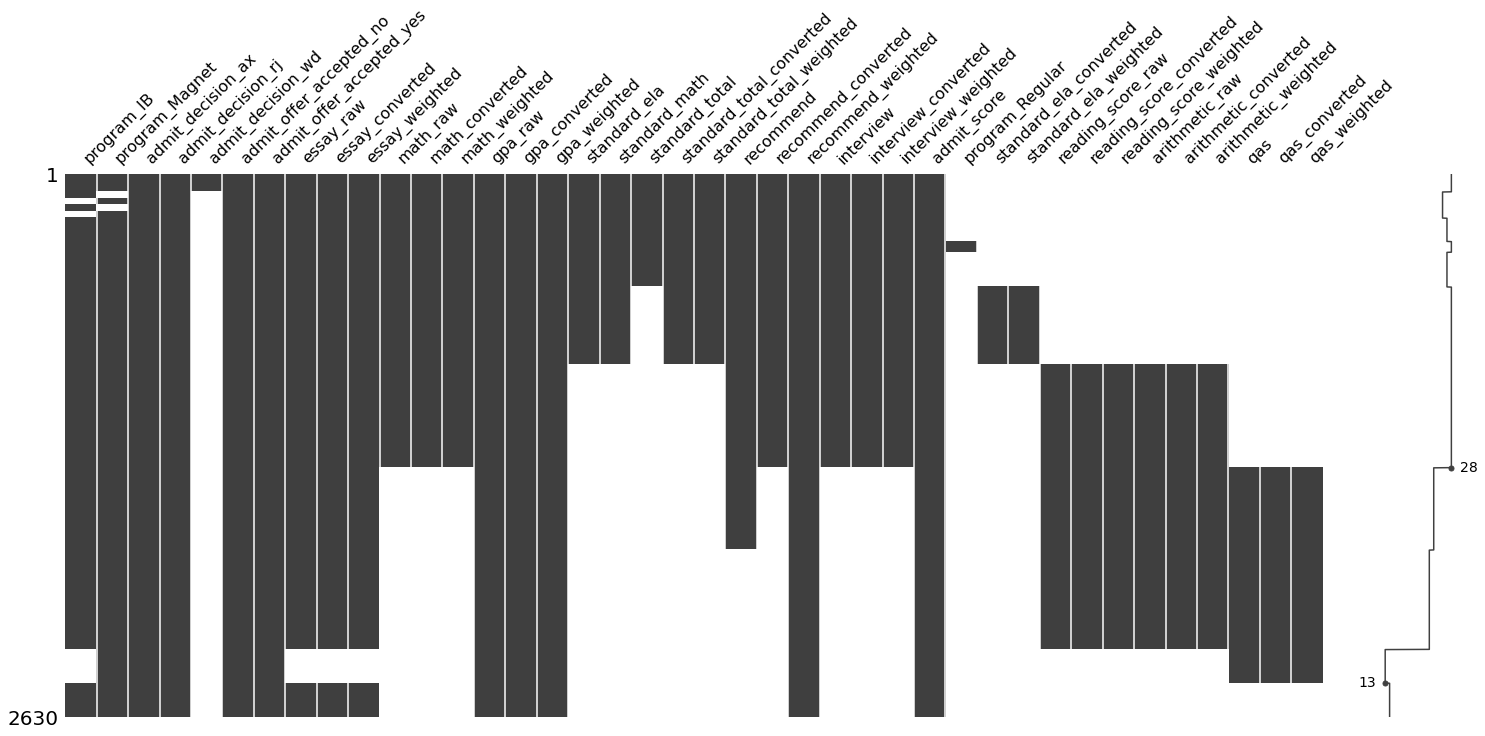

In [4]:
msno.matrix(df)

In [5]:
'''Combine data columns'''
df['math_raw'] = df['math_raw'].combine_first(df['arithmetic_raw'])
df['math_converted'] = df['math_converted'].combine_first(df['arithmetic_converted'])
df['math_weighted'] = df['math_weighted'].combine_first(df['arithmetic_weighted'])

df['standard_ela'] = df['standard_ela'].combine_first(df['reading_score_raw'])

<AxesSubplot:>

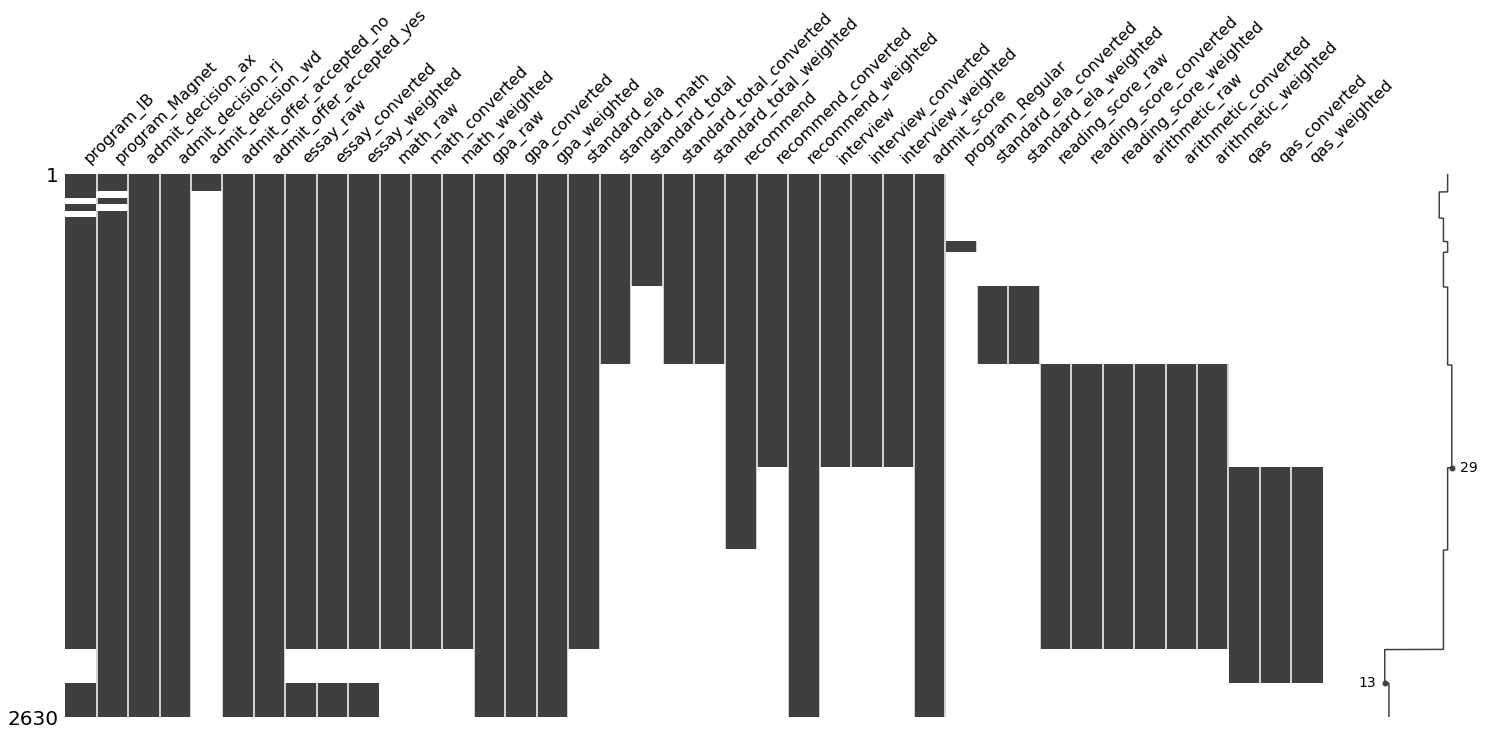

In [6]:
msno.matrix(df)

In [7]:
'''Further combine data columns'''
df['math_raw'] = df['math_raw'].combine_first(df['qas'])
df['math_converted'] = df['math_converted'].combine_first(df['qas_converted'])
df['math_weighted'] = df['math_weighted'].combine_first(df['qas_weighted'])

<AxesSubplot:>

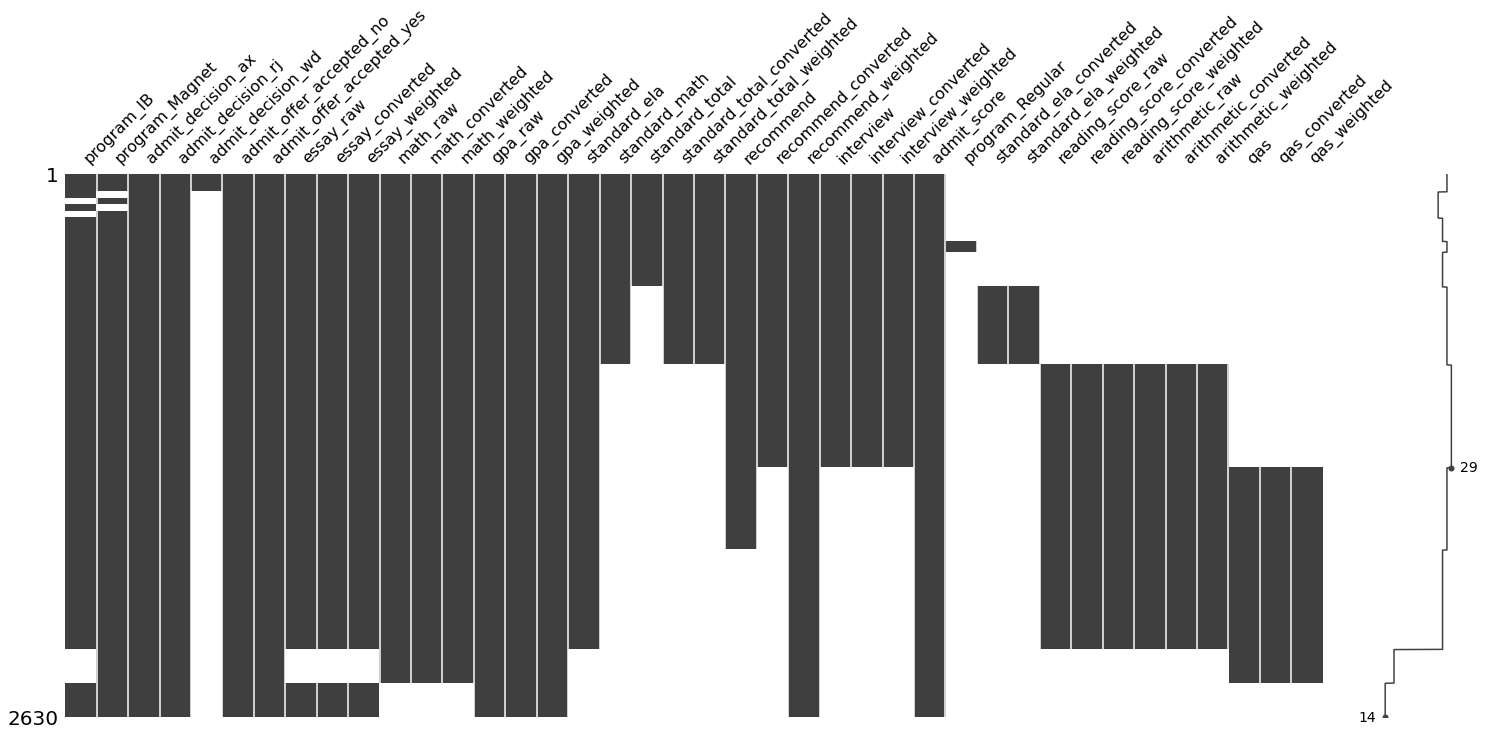

In [8]:
msno.matrix(df)

In [9]:
'''Drop duplicate and/or sparse columns'''
df.drop(['admit_decision_wd', 'standard_math', 'standard_total', 'standard_total_converted', 'standard_total_weighted',\
         'program_Regular','standard_ela_converted', 'standard_ela_weighted', 'reading_score_raw','reading_score_converted',\
         'reading_score_weighted', 'arithmetic_raw', 'arithmetic_converted', 'arithmetic_weighted', 'qas', 'qas_converted',\
         'qas_weighted'], axis = 1, inplace=True)

<AxesSubplot:>

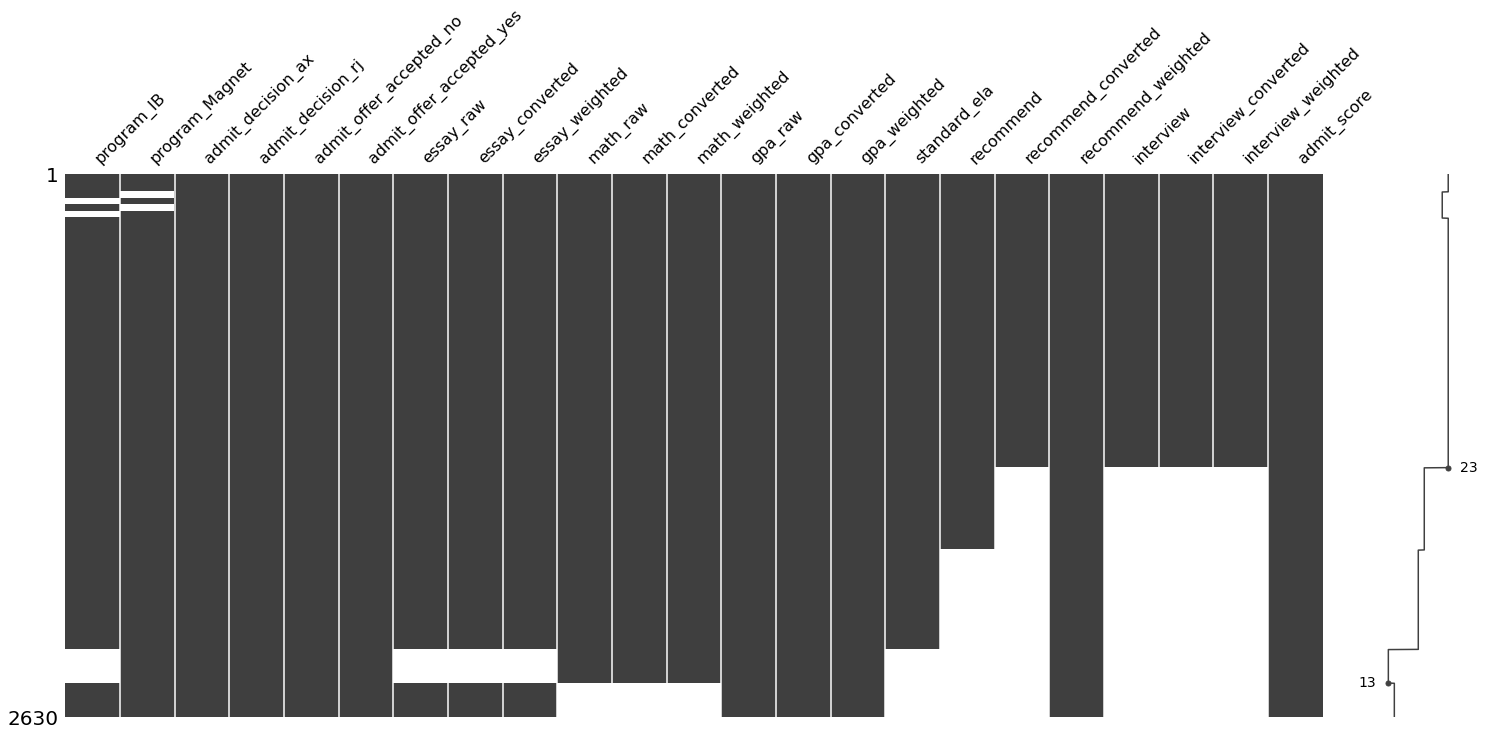

In [10]:
msno.matrix(df)

In [11]:
'''Fill NaNs in program columns'''

df['program_IB'].replace(np.nan, 0, inplace = True)
df['program_Magnet'].replace(np.nan, 0, inplace = True)

In [12]:
'''Create column for program/acceptance status'''
conditions = [
    (df['program_IB'] == 0) & (df['admit_decision_ax'] == 0),
    (df['program_IB'] == 0) & (df['admit_decision_ax'] == 1),
    (df['program_IB'] == 1) & (df['admit_decision_ax'] == 0),
    (df['program_IB'] == 1) & (df['admit_decision_ax'] == 1)]

values = ['Magnet-Rejected', 'Magnet-Accepted', 'IB-Rejected', 'IB-Accepted']

df['program_admit'] = np.select(conditions, values)

In [13]:
'''Create separate dataframes for magnet and ib'''
ib_df = df.loc[df['program_IB'] == 1]
magnet_df = df.loc[df['program_IB'] == 0]

In [14]:
df.columns
plot_list = ['program_admit','essay_raw', 'math_raw', 'gpa_raw','standard_ela', 'recommend', 'interview']

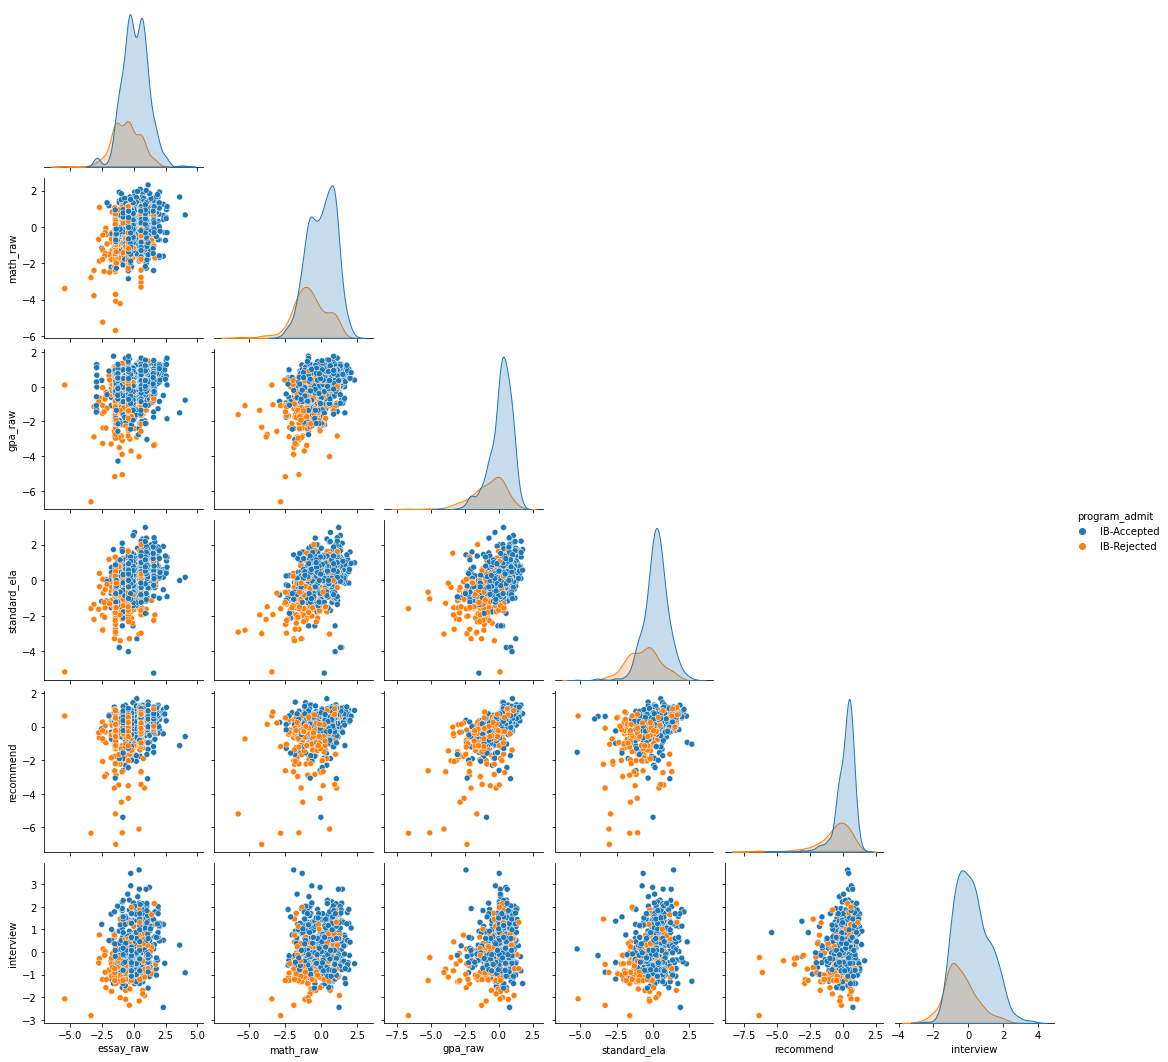

In [16]:
'''Create pariplots to show relationships between variables - IB'''
sns.pairplot(ib_df[plot_list], kind = 'scatter', hue = 'program_admit', corner = True)

<AxesSubplot:>

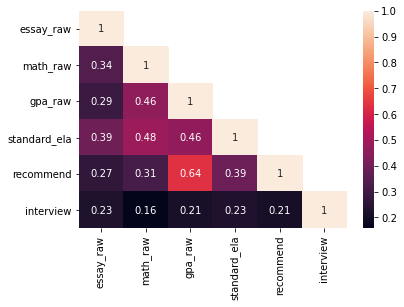

In [17]:
'''Correlation Heatmap - IB'''
df_corr_ib = ib_df[plot_list].corr()
matrix = pd.DataFrame(np.tril(df_corr_ib), columns = df_corr_ib.columns).replace(0, np.nan)
matrix.set_index(df_corr_ib.columns, drop = True, inplace = True)
sns.heatmap(matrix, annot=True)

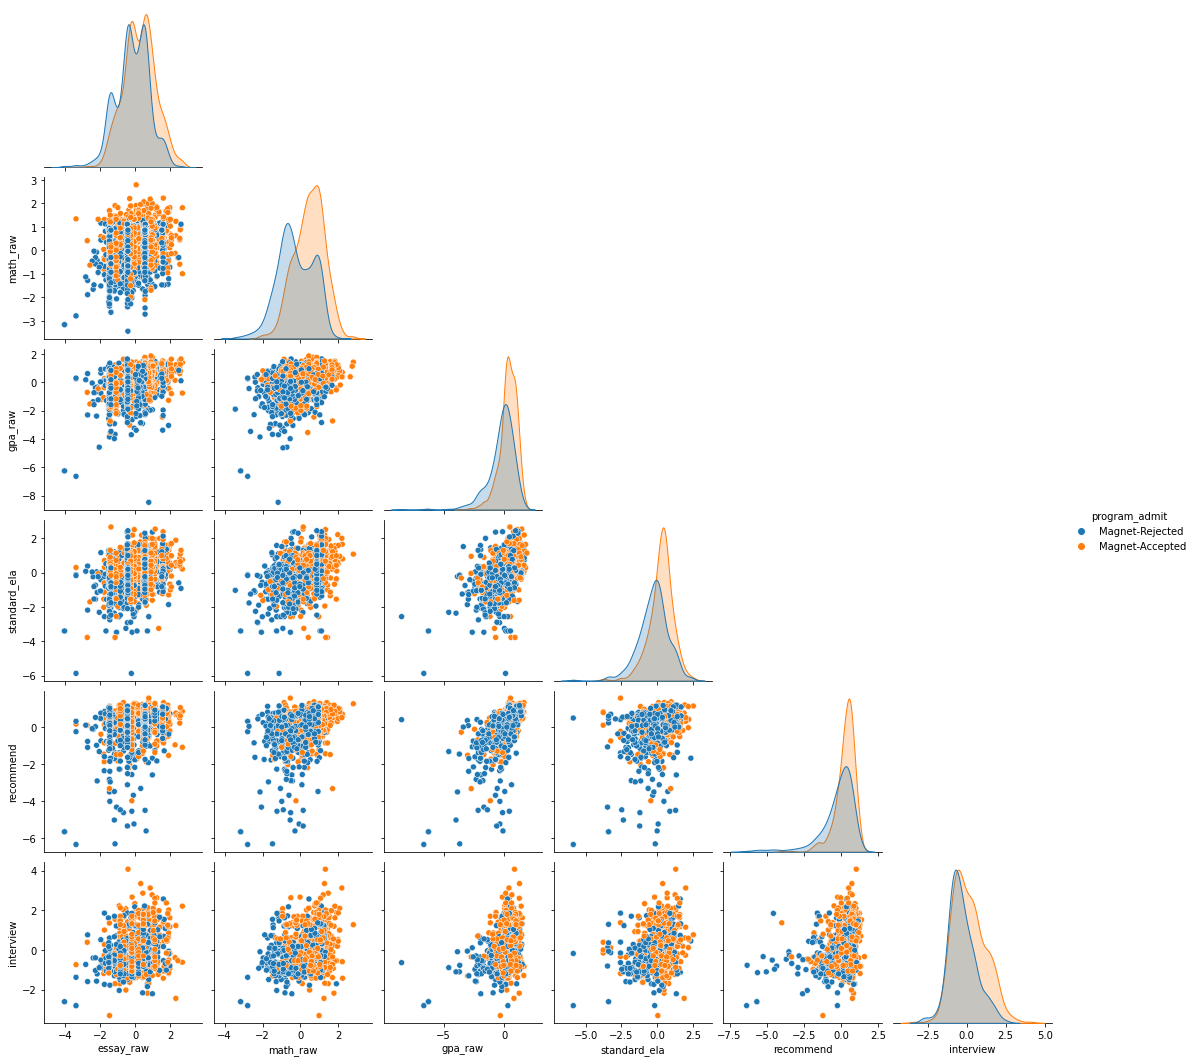

In [18]:
'''Create pariplots to show relationships between variables - Magnet'''
sns.pairplot(magnet_df[plot_list], kind = 'scatter', hue = 'program_admit', corner = True)

<AxesSubplot:>

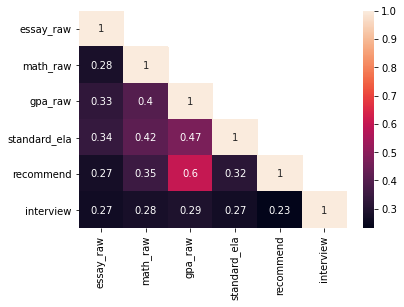

In [19]:
'''Correlation Heatmap - Magnet'''
df_corr_magnet = magnet_df[plot_list].corr()
matrix = pd.DataFrame(np.tril(df_corr_magnet), columns = df_corr_magnet.columns).replace(0, np.nan)
matrix.set_index(df_corr_magnet.columns, drop = True, inplace = True)
sns.heatmap(matrix, annot=True)

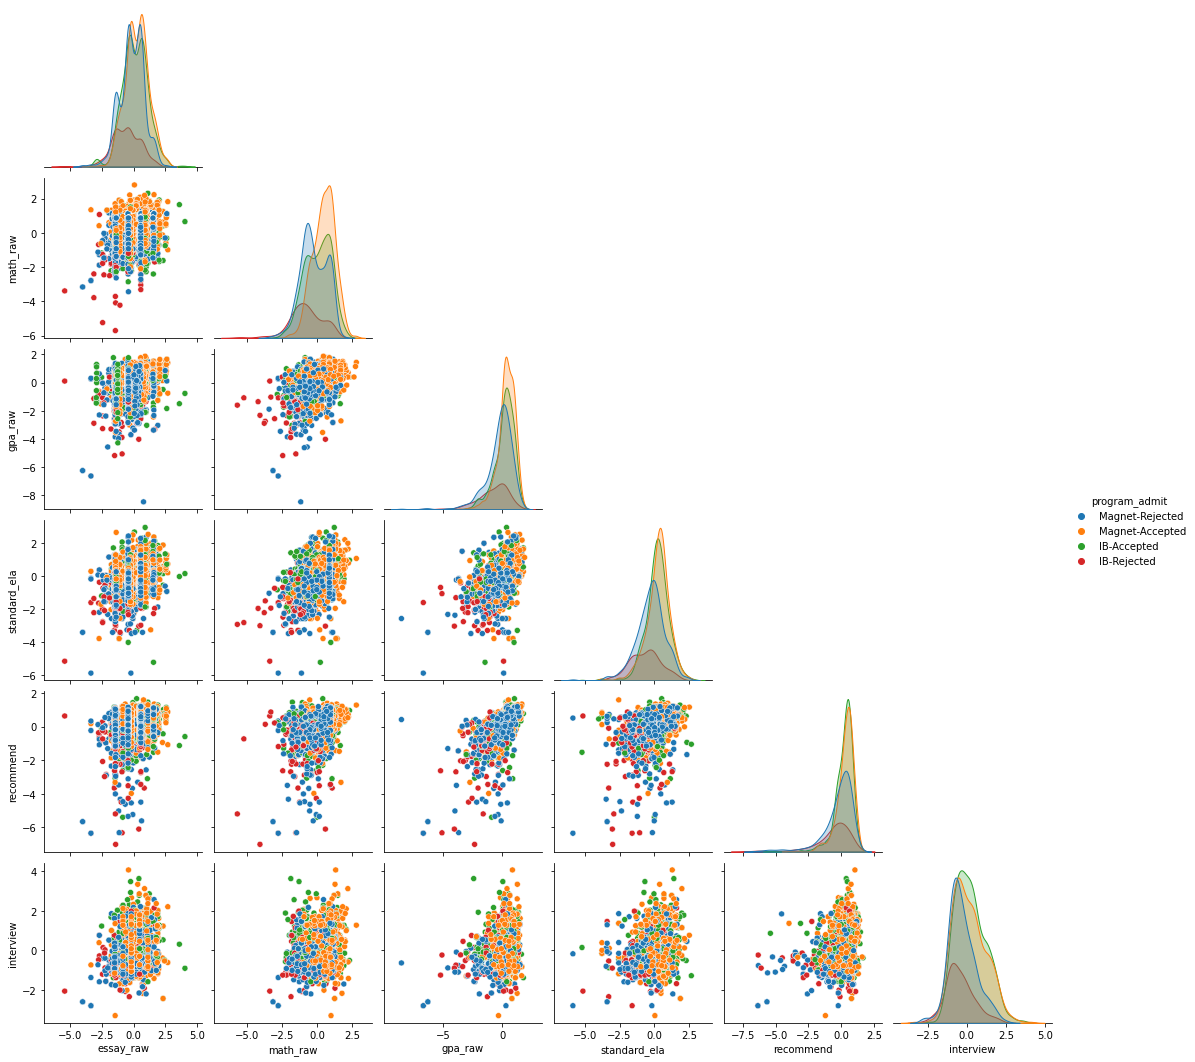

In [20]:
'''Create pariplots to show relationships between variables'''
sns.pairplot(df[plot_list], kind = 'scatter', hue = 'program_admit', corner = True)

<AxesSubplot:>

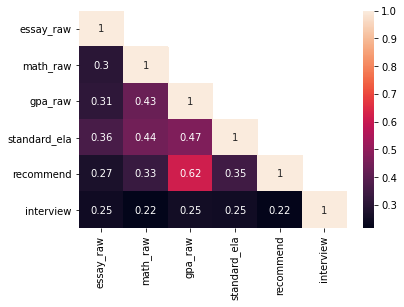

In [21]:
df_corr = df[plot_list].corr()
matrix = pd.DataFrame(np.tril(df_corr), columns = df_corr.columns).replace(0, np.nan)
matrix.set_index(df_corr.columns, drop = True, inplace = True)
sns.heatmap(matrix, annot=True)

<AxesSubplot:>

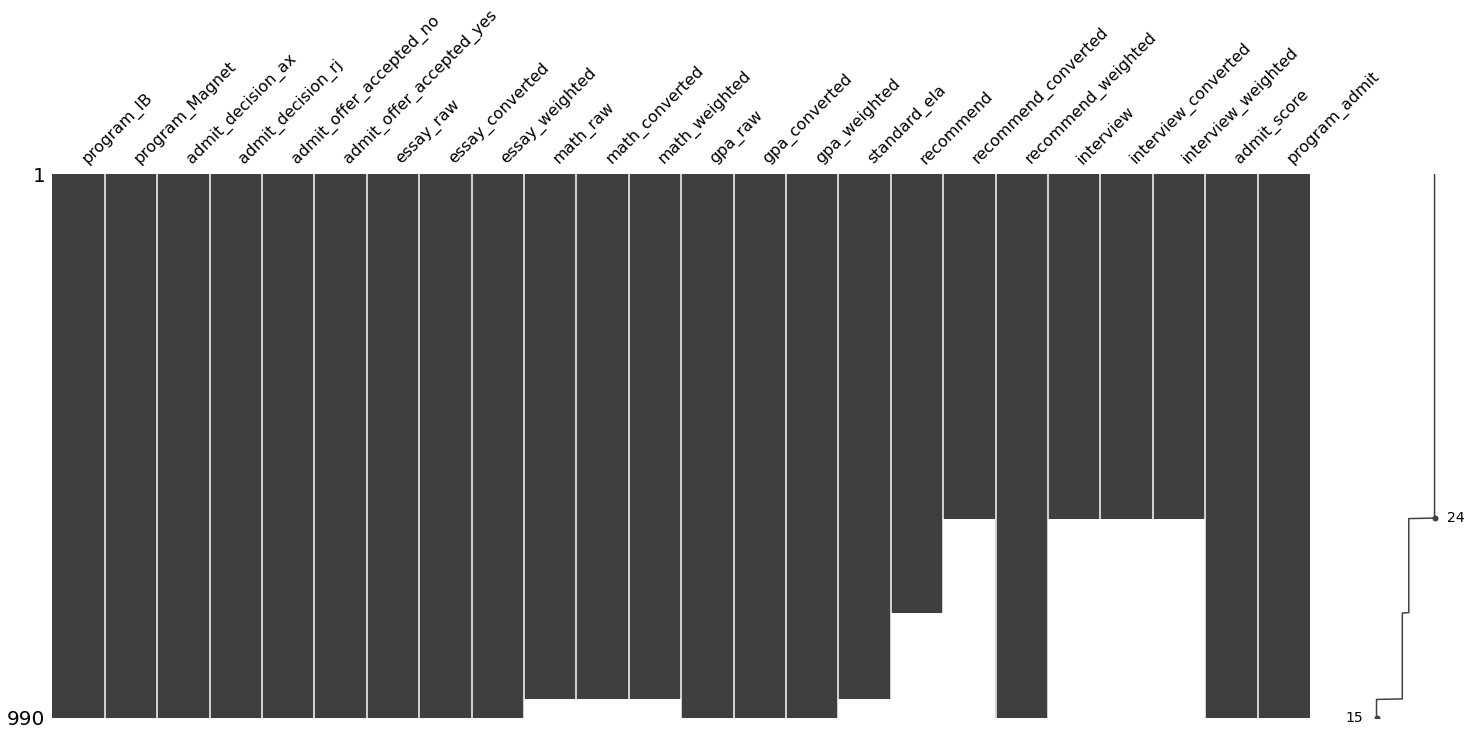

In [22]:
msno.matrix(ib_df)

In [164]:
'''Function to perform PCA analysis'''

'''Split data into test and train IB'''
def conduct_pca(df, pca_list, n_components):
    X = df[pca_list].drop(pca_list[0], axis = 1)
    y = df[pca_list[0]]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, stratify = y, random_state=42)
    
    '''Create PCA model'''
    model = pca(n_components = n_components)
    model.fit(X_train, y_train)
    
    '''Find cumulative variance of components'''
    cum_variance = np.cumsum(pca.explained_variance_ratio_*100)
    variance = pca.explained_variance_ratio_*100

    '''Print explained variance with all factors'''
    print(f'Cumulative variance explained by model {cum_variance}')
    print(f'The explained variance for each factor is: {variance}')
    
    '''Create Scree Plot'''
    PC_values = np.arange(pca.n_components_) + 1
    plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Proportion of Variance Explained')
    plt.xticks(np.arange(1,6,1));

    return modelas, X, X_test, y_test

### IB PCA Analysis

In [165]:
ib_df_drop = ib_df.dropna(how = 'any')

<AxesSubplot:>

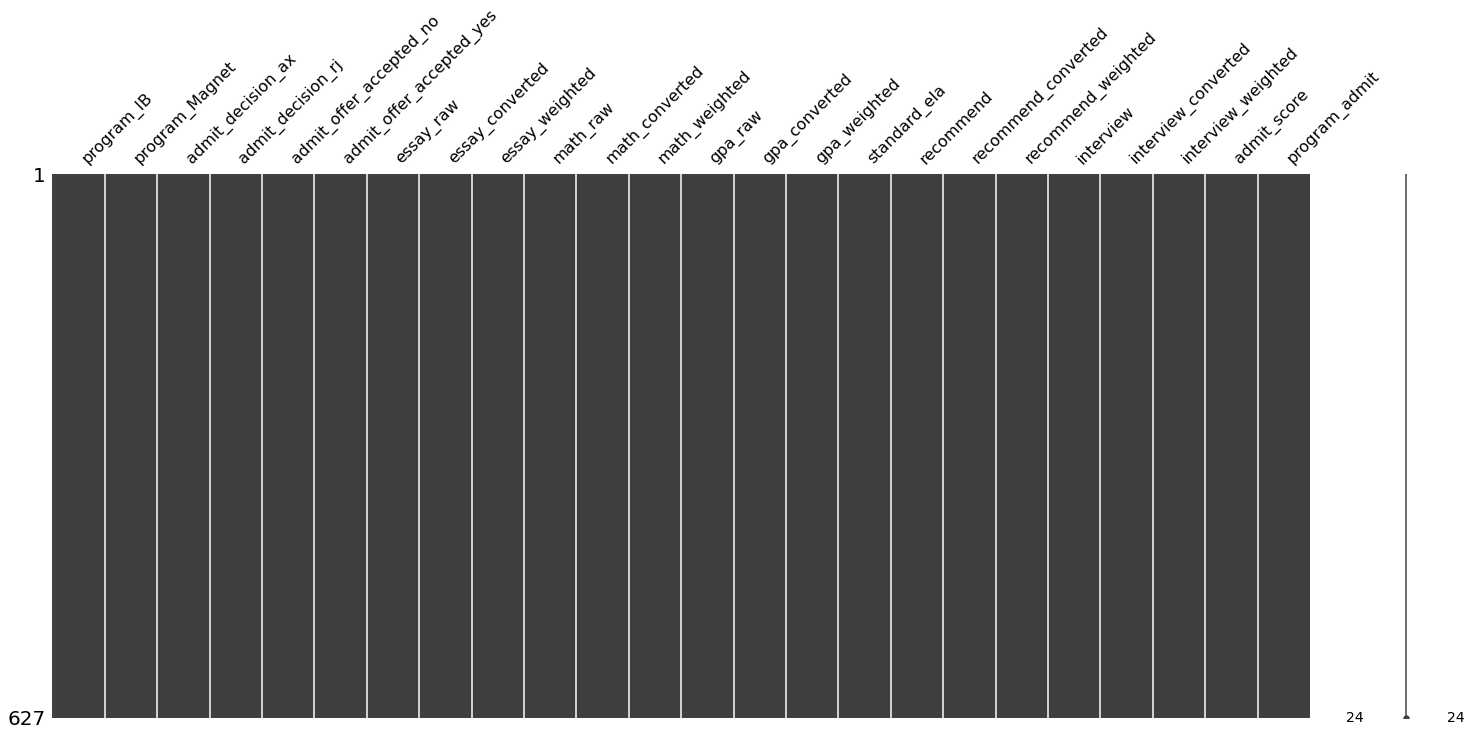

In [166]:
msno.matrix(ib_df_drop)

Cumulative variance explained by model [ 44.10395184  59.38965255  73.58882385  84.87155882  94.62461579
 100.        ]
The explained variance for each factor is: [44.10395184 15.28570071 14.1991713  11.28273497  9.75305697  5.37538421]


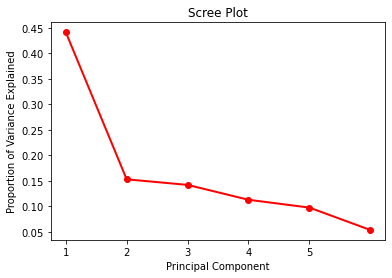

In [167]:
'''Conduct PCA on IB data with 6 components'''
pca_list = ['admit_decision_ax','essay_raw', 'math_raw', 'gpa_raw','standard_ela', 'recommend', 'interview']
pca = conduct_pca(ib_df_drop, pca_list, 6)

Cumulative variance explained by model [44.10395184 59.38965255]
The explained variance for each factor is: [44.10395184 15.28570071]


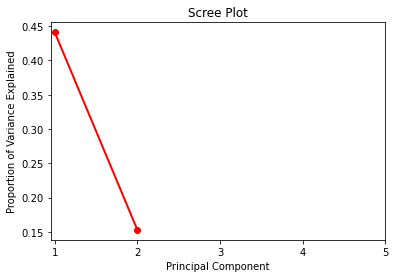

In [134]:
'''Conduct PCA on IB data with 2 components'''
pca_list = ['admit_decision_ax','essay_raw', 'math_raw', 'gpa_raw','standard_ela', 'recommend', 'interview']
pca = conduct_pca(ib_df_drop, pca_list, 2)

In [135]:
'''Calculate pc loadings - IB'''
pd.options.display.float_format = '{:,.4f}'.format
loadings = pd.DataFrame(pca[0].components_.T, columns=['PC1', 'PC2'], index=pca[1].columns)
loadings

,PC1,PC2
essay_raw,-0.3350,-0.5458
math_raw,-0.4110,0.0693
gpa_raw,-0.5103,0.4062
standard_ela,-0.4321,-0.0804
recommend,-0.4430,0.3519
interview,-0.2747,-0.6340


### Magnet PCA Analysis

In [136]:
magnet_df_drop = magnet_df.dropna(how = 'any')

<AxesSubplot:>

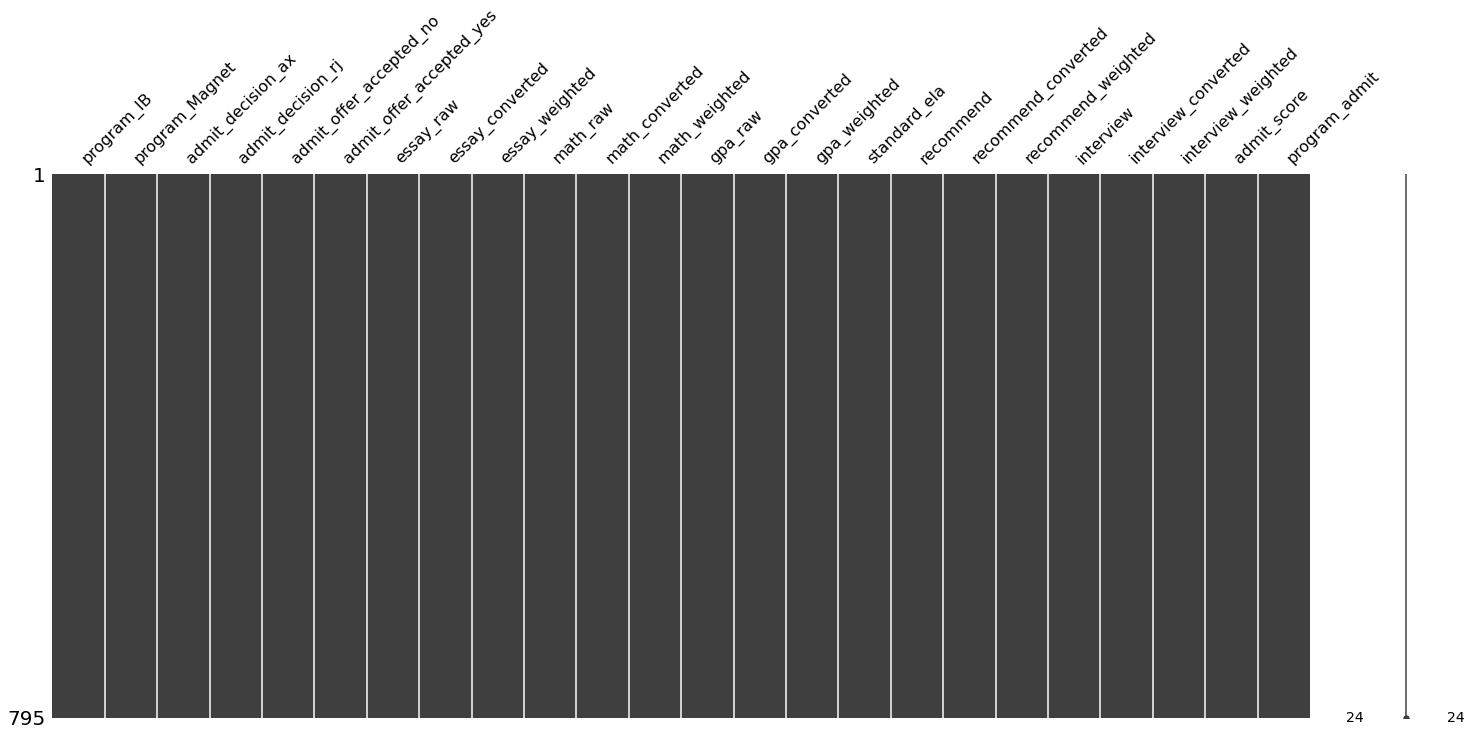

In [137]:
msno.matrix(magnet_df_drop)

Cumulative variance explained by model [ 47.31950419  61.77792721  74.70556702  85.1361913   94.11889624
 100.        ]
The explained variance for each factor is: [47.31950419 14.45842302 12.92763981 10.43062428  8.98270494  5.88110376]


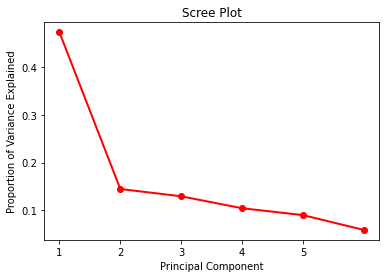

In [147]:
'''Conduct PCA on IB data with 6 components'''
pca_list = ['admit_decision_ax','essay_raw', 'math_raw', 'gpa_raw','standard_ela', 'recommend', 'interview']
pca = conduct_pca(magnet_df_drop, pca_list, 6)

Cumulative variance explained by model [47.31950419 61.77792721]
The explained variance for each factor is: [47.31950419 14.45842302]


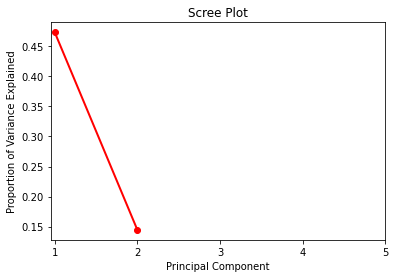

In [148]:
'''Conduct PCA on IB data with 2 components'''
pca_list = ['admit_decision_ax','essay_raw', 'math_raw', 'gpa_raw','standard_ela', 'recommend', 'interview']
pca = conduct_pca(magnet_df_drop, pca_list, 2)

In [149]:
'''Calculate pc loadings - Magnet'''
pd.options.display.float_format = '{:,.4f}'.format
loadings = pd.DataFrame(pca[0].components_.T, columns=['PC1', 'PC2'], index=pca[1].columns)
loadings

,PC1,PC2
essay_raw,-0.3583,0.4274
math_raw,-0.3860,0.0328
gpa_raw,-0.4835,-0.3519
standard_ela,-0.4182,0.2085
recommend,-0.4485,-0.5931
interview,-0.3360,0.5452


In [150]:
pca_trans = pca[0].transform(pca[2])

In [151]:
pca_trans_df = pd.DataFrame(pca_trans, columns = ['PC1', 'PC2'])

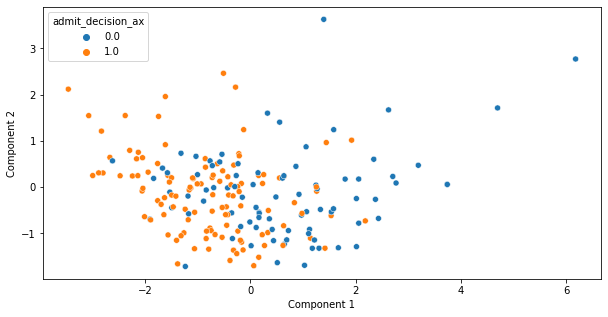

In [152]:
'''Plot Primary Components'''
plt.figure(figsize=(10,5))
sns.scatterplot(x = pca_trans[:,0], y = pca_trans[:,1], hue = pca[3])
plt.xlabel('Component 1')
plt.ylabel('Component 2');

In [153]:
fig, ax = pca[0].biplot(n_feat=4, PC=[0,1])

AttributeError: 'PCA' object has no attribute 'biplot'